[View in Colaboratory](https://colab.research.google.com/github/rukmal/PaperRank-Analysis/blob/master/analysis.ipynb)

# PubMed PaperRank Analysis

---

This notebook contains the analysis of the PubMed PaperRank dataset.

For more information, see the PaperRank GitHub Page: [[GitHub]](http://github.com/rukmal/PaperRank)

**IMPORTANT**

To use the [Model Explorer](#scrollTo=NyfDNBG5Fpce), you need to run a portion of this notebook. Speficially, the data loading and model training sections. Follow the steps below to do this without running unnecessary computations:
1. Go to [this](#scrollTo=0ESNE47Kfr_N) code block, and select *Run before* (`⌘/Ctrl+F8` or *Runtime -> Run before*)
  - **Note:** You may be required to sign in to your Google account [here](#scrollTo=njsus7GqJic6)
2. Go to [this](#scrollTo=JlunJxODSQ7b) code block, and select *Run after* (`⌘/Ctrl+F10` or *Runtime -> Run after*)
  - **Note:** The [model training](#scrollTo=QOUoEzbaS6Xl) step will take some time

## Table of Contents

>[PubMed PaperRank Analysis](#scrollTo=8jGksJd5QnM4)

>>[Table of Contents](#scrollTo=y_sS4--HKREg)

>>[Notebook Setup](#scrollTo=ijJJ7LbhHzL4)

>>>[Package Installation](#scrollTo=NGB-tRhhJQY6)

>>>[Jupyter Configuration](#scrollTo=5XWRs08Kb-mm)

>>>[Module Imports](#scrollTo=l0cEoNCCIsv3)

>>>[Authentication](#scrollTo=5DqUD3meJYET)

>>>[Data Loading](#scrollTo=0qvzoVp7IZrk)

>>>[Data Cleaning](#scrollTo=cGgVt2oHNM9V)

>>>[Descriptive Statistics](#scrollTo=53zc_iYwQLQF)

>>>[Plot Setup](#scrollTo=nWIqj4Vgzc9P)

>>>[Publication Metadata](#scrollTo=3X5YcPOfdVvt)

>>>[Mixture Model Visualization](#scrollTo=GDNo0jJ8vgin)

>>>[PubMed Search API](#scrollTo=7z9RXll6xpTy)

>>>[Model Output Cleaning](#scrollTo=YAoReNmV_ekX)

>>>[Helper Functions](#scrollTo=cpXEPs8CBpEo)

>>[Distribution Analysis](#scrollTo=ULVJyFvyRps6)

>>>[Descriptive Statistics](#scrollTo=ZFl2_pJPZ8Qy)

>>>[Distribution Plots](#scrollTo=CXoiFt3TbnyA)

>>>>[Box Plot](#scrollTo=WuEpFd1kyfWF)

>>>>[Histogram](#scrollTo=uxRmRGXA5J6B)

>>>>[Scatter Plot](#scrollTo=0RaFfvgv69l-)

>>[Frequency Distribution Analysis](#scrollTo=Ji5zfEe5F-ej)

>>>[Max PaperRank Publication Analysis](#scrollTo=SLnR_DHoQC7u)

>>>[Outlier Analysis](#scrollTo=o2AutSKdYG7F)

>>[Bayesian Gaussian Mixture Model](#scrollTo=LYBjY1wR_U6E)

>>>[Overview](#scrollTo=V296flhrQFKY)

>>>[Heuristic Convergence Test](#scrollTo=CllXSg5TRri7)

>>>[Model Training](#scrollTo=QOUoEzbaS6Xl)

>>>[Model Analysis](#scrollTo=YFWb-Z7bTFdc)

>>>>[Visualization](#scrollTo=z9rEGQIRTNft)

>>>>[Parameters](#scrollTo=8com-ImqT2E2)

>>>[Model Explorer](#scrollTo=NyfDNBG5Fpce)



## Notebook Setup

This section sets up core functionality required for the Jupyter notebook. This includes file loading, parsing and some basic data cleaning. It also contains source code for some helper modules used in the notebook.

This dataset is imported from the `paperrank-data` directory, which is in the same directeory as this notebook on Google Drive. The entire `output/` folder was copied from the PaperRank repository, and simply renamed to `paperrank-data`.

### Package Installation

This section contains logic for installing required packages.

In [0]:
# Installing PyDrive
!pip install -U -q PyDrive

# Installing seaborn (viz library)
!pip install -U -q seaborn

# Installing pubmed-lookup (PubMed query library)
!pip install -U -q pubmed-lookup

### Jupyter Configuration

Suppress warnings.

In [0]:
import warnings

warnings.filterwarnings('ignore')

### Module Imports

This section contains module imports used by this script. The imports are grouped by their corresponding functionality for clarity.

In [0]:
# Google Drive file loading/exporting
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Formatting
from IPython.display import display, HTML

# Data loading
from io import StringIO

# Data manipulation
from scipy import stats
import numpy as np
import pandas as pd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# PubMed data
from pubmed_lookup import PubMedLookup, Publication

# Mixture models
from math import sqrt
from matplotlib.patches import Ellipse
from sklearn import mixture

# Search imports
from requests import get
import re

### Authentication

This section contains logic for authenticating the user with Google Drive. Follow the prompts here for Google Drive operations to function correctly.

This functionality is adapted from the official Google Colab guide on handling external data, which can be found [here](https://colab.research.google.com/notebooks/io.ipynb).

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Data Loading

This section contains the logic for loading the `paperrank.csv` file from the `paperrank-data/` folder.

The function below loads and parses a CSV file from Google Drive to a Pandas DataFrame. This functionality is implemented using the `PyDrive` package, whose documentation is [here](https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html).

In [0]:
def loadCSVFile(id: str) -> pd.DataFrame:
  """Function to get and load a CSV file from Google Drive into a
  Pandas `pd.DataFrame` object.
  
  Arguments:
    id {str} -- Google Drive ID of the file to be downloaded. This can be found
                by turning on 'Link Sharing' in Drive, and copying the ID from
                the resulting URL.
  """

  # Getting file from Google Drive
  downloaded_file = drive.CreateFile({'id': id})
  downloaded_file_serialized = StringIO(downloaded_file.GetContentString())
  
  # Parsing StringIO to DataFrame
  csv_parsed = pd.read_csv(downloaded_file_serialized)
  
  print('Read CSV file to Pandas DataFrame with dimensions', csv_parsed.shape)
  
  return csv_parsed

Loading the `paperrank.csv` file from Google Drive.

In [7]:
paperrank_id = '1zYkuS_a7Val6dRR-GpNwouUuMlOVDmT5'

global pr_df
pr_df = loadCSVFile(paperrank_id)

Read CSV file to Pandas DataFrame with dimensions (14483643, 2)


### Data Cleaning

This section contains logic to load data from the `pr_df` DataFrame to `numpy` arrays for faster statistical operations.

In [0]:
# Creating np.array of IDs
global pr_id
pr_id = np.array(pr_df['PubMed ID'], dtype=np.int)

# Creating np.array of PaperRanks
global pr_rank
pr_rank = np.array(pr_df['PaperRank'], dtype=np.float)

# Creating np.array of Log(PaperRank)
global pr_log
pr_log = np.log(pr_rank)

# Get descending sort index
global sort_idx
pr_sort_idx = np.argsort(pr_rank, axis=0)[::-1]

### Descriptive Statistics

The section contains logic to compute basic descriptive statistics for a distribution.

In [0]:
def computeDescriptiveStatistics(data: np.array) -> dict:
  """Function to compute descriptive statistics for a given distribution.
  
  Arguments:
    data {np.array} -- Statistics for computation.
  
  Returns:
    {dict} -- Dictionary with descriptive statistics.
  """

  desc_stats = dict()

  # Computing descriptive stats
  desc_stats['mean'] = np.mean(data)
  desc_stats['sd'] = np.std(data)
  desc_stats['var'] = np.var(data)
  desc_stats['skew'] = stats.skew(data)
  desc_stats['kurtosis'] = stats.kurtosis(data)
  desc_stats['median'] = np.median(data)
  desc_stats['min'] = np.amin(data)
  desc_stats['max'] = np.amax(data)
  desc_stats['range'] = desc_stats['max'] - desc_stats['min']
  desc_stats['N'] = data.size
  
  return desc_stats

### Plot Setup

This section contains logic to set up the plot-related things. The first block contains configuration items, and the second contains a funciton to build a subplot for the plots.

In [0]:
# Setting plot style to dark
sns.set_style('darkgrid')

# Setting plot title size to xx-large from large
plt.rcParams['figure.titlesize'] = 'xx-large'

In [0]:
# Defining dimensions
# key: (width, height) [inches]
global dims_normal
dims_normal = (11.7, 8.27)
global dims_large
dims_large = (20, 11)

def getSubplot(dimensions: tuple) -> tuple:
  """Function to get a subplot for plotting, formatted to the
  correct dimensions.
  
  Arguments:
    dimensions {tuple} -- Dimensions tuple in the form of (width, height)
                          in inches.
  
  Returns:
    tuple -- PyPlot Figure and Axes for plotting with Seaborn.
  """

  fig, ax = plt.subplots(figsize=dimensions)
  return fig, ax

### Publication Metadata

The following code implements publication metdata downloading from PubMed for a given ID, using the [`pubmed_lookup` package](https://github.com/mfcovington/pubmed-lookup).

In [0]:
def getPublicationMetadata(pmid: str) -> list:
  # Configuration
  base_url = 'http://www.ncbi.nlm.nih.gov/pubmed/'
  email = ''
  
  # Building query URL
  query_url = base_url + pmid
  lookup = PubMedLookup(query_url, email)
  
  # Instantiating publication object
  publication = Publication(lookup)

  # Returning relevant list of metadata
  return [publication.title, publication.authors, publication.year, \
          publication.abstract]

### Mixture Model Visualization

The following code implements plotting functionality for the mixture models.

In [0]:
def drawEllipse(position: np.ndarray, covariance: object, ax: object,
                n_sd: int=2, **kwargs):
  """Draw an ellipse of a distribution on a graph, given its position and
  covariance.
  
  Arguments:
    position {np.ndarray} -- Position of the distribution on the graph.
    covariance {object} -- Covariance of the distribution.
    ax {object} -- Axis the Ellipse will be plotted on.
    
  Keyword Arguments:
    n_sd {int} -- Number of standard deviations to draw. (default: {2})
  """
  
  # Compute width, height and angle depending on covariance type
  if covariance is int:
    # Using covariance_type 'spherical'
    width = 2 * sqrt(covariance)
    height = width
    angle = 0
  if covariance.shape == (2, 2):
    # Using covariance_type 'full' or 'tied'
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
  else:
    # Using covariance_type 'diag'
    width, height = 2 * np.sqrt(covariance)
    angle = 45

  
  # Draw the Ellipse
  for nsig in range(1, n_sd + 1):
    ax.add_patch(Ellipse(xy=position, width=(nsig * width),
                         height=(nsig * height), angle=angle, **kwargs))

def drawMixtureModel(model: mixture.BayesianGaussianMixture, preds: np.ndarray,
                     X: np.ndarray, ax: object, set_title: bool=True,
                     transparency: float=0.4, label: bool=True):
  """Draw a mixture model on a plot, with ellipses over component distribution
  covariances.
  
  Arguments:
    model {mixture.BayesianGaussianMixture} -- Trained mixture model.
    preds {np.ndarray} -- Predictions from the model.
    X {np.ndarray} -- Dataset used to compute predictions.
    ax {object} -- Axes to plot the model.

  Keyword Arguments:
    set_title {bool} -- Flat to toggle plot title with training size.
    transparency {float} -- Transparency factor of ellipses. (default: {0.4})
    label {bool} -- Flag to toggle label printing. (default: {True})
  """
  
  # Check if we plot labels (i.e. colors)
  if label:
     # `s` is point size
    ax.scatter(X[:, 0], X[:, 1], cmap='RdYlGn', c=preds, marker='x', s=1)
  else:
    ax.scatter(X[:, 0], X[:, 1], marker='x')
    
  # Transparency
  w_factor = transparency / model.weights_.max()
  
  # Plot Ellipse for each distribution
  for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
    # Set title
    if set_title:
      title = 'Training size: ' + '{:,}'.format(len(X[:, 0]))
      ax.set_title(title)
    
    # Transparency
    alpha = w * w_factor

    # Draw Ellipse
    drawEllipse(position=pos, covariance=covar, ax=ax, alpha=alpha)

### PubMed Search API

This section contains logic for the PubMed Search API, used in the model explorer.

In [0]:
def pubMedSearch(term: str) -> np.array:
  """This function searches PubMed for a given term, and returns result IDs.
  
  Arguments:
    term {str} -- Search term.
  
  Returns:
    {np.array} -- Array of result IDs.
  """
  
  # API URL
  base_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'

  # Request parameters
  request_parameters = {'db': 'pubmed', 'term': term}

  # Making request
  r = get(url=base_url, params=request_parameters)

  # Defining filter
  regex_filter = '\<Id\>(.*)\<\/Id\>'
  
  # Finding the result
  result = re.findall(regex_filter, r.text)

  return np.array(result, dtype=int)

### Model Output Cleaning

This section contains logic for fixing the order of predictions, and the order of other variables in the model.

For an unknown reason, the `mixture.BayesianGaussianMixture` module from `sklearn` does not return the probabilities of predictions being in a given category in order. Because of this, we must manually re-order the list. This function reorders an expected prediction size of 3. This function must be re-implemented if the number of components in the model is changed.

Note that this function assumes the PaperRank of PubMed ID `6582628` has the highest PaperRank, and that `3955228` has a low PaperRank. These may need to be adjusted in the future.

In [0]:
def cleanPredictions(pr_preds: np.ndarray) -> np.ndarray:
  """Function to clean the order of predictions, given an order. Note that
  this will have to be re-implemented depending on the number of components
  used in the model.
  
  Arguments:
    pr_preds {np.ndarray} -- PaperRank model predictions.

  Returns:
    np.ndarray -- New `pr_pred` in the correct order.
  """

  
  # Determining order
  high_idx = 6582628  # SHELX, PMID: 18156677
  low_idx = 3955228  # Johnson, et al., PMID: 22576581
  
  # Getting high and low predictions
  high_pred = pr_preds[high_idx]
  low_pred = pr_preds[low_idx]

  # Getting high and low indices
  high_pred_idx = [int(round(i)) for i in high_pred]
  low_pred_idx = [int(round(i)) for i in low_pred]
  
  # Creating order
  order = [1] * 3

  # Set high and low indexes
  order[high_pred_idx.index(1)] = 2
  order[low_pred_idx.index(1)] = 0

  # Creating new predictions
  new_preds = []
  
  # Iterate through predictions
  for pred in pr_preds:
    # Create new predictions in correct order
    clean_pred = np.array([pred[o] for o in order], dtype=np.float)
    # Append to list
    new_preds += [clean_pred]
  
  return np.array(new_preds)

This function puts the parameters from the model in the correct order.

In [0]:
def cleanParameter(parameter: list, order: list) -> list:
  """Function to fix the order of a parameter list, given an order.
  
  Arguments:
    parameter {list} -- List of parameters to be fixed.
    order {list} -- Correct order of the elements (by index).
  
  Returns:
    np.ndarray -- New `parameter` in the correct order.
  """
  
  
  new_params = [parameter[o] for o in order]
  
  return new_params

### Helper Functions

This section contains miscellaneous helper functions.

The following function can be used to format a link with the proper HTML.

In [0]:
def makeClickable(url):
  """Function to make an HTML link.
  
  Arguments:
    url {str} -- URL to be embedded in HTML.
  """
  link = '<a href="{0}">link</a>'.format(url)
  return link

## Distribution Analysis

This section contains the distribution analysis of the PaperRank scores.

### Descriptive Statistics

This section contains descriptive statistics for the `PaperRank` and `Log PaperRank` distributions.

To get a better idea of the underlying distribution, while still preserving the order of the data, we can borrow a technique from Financial Engineering; apply a monotonic transformation to augment the distance between points clustered together, and diminish the distance of outliers in the distribution. To accomplish this, we will use the `log` function on the entire PaperRank datastet.

In [18]:
global pr_stats
pr_stats = computeDescriptiveStatistics(data=pr_rank)

global pr_log_stats
pr_log_stats = computeDescriptiveStatistics(data=pr_log)

# Create DataFrame (for display)
pr_stats_df = pd.DataFrame.from_dict([pr_stats.values(), pr_log_stats.values()])
pr_stats_df = pr_stats_df.T

# Set index and index title
pr_stats_df.index.name = 'Statistic'
pr_stats_df.index = list(pr_stats.keys())
# Set column names
pr_stats_df.columns = ['PaperRank', 'Log PaperRank']

# Displaying table
pr_stats_df

,PaperRank,Log PaperRank
mean,6.904340e-08,-1.679416e+01
sd,2.138320e-07,6.344974e-01
var,4.572415e-14,4.025870e-01
skew,6.985549e+02,1.553334e+00
kurtosis,1.153276e+06,3.291845e+00
median,3.877627e-08,-1.706546e+01
min,2.967191e-08,-1.733306e+01
max,4.225609e-04,-7.769177e+00
range,4.225312e-04,9.563888e+00
N,1.448364e+07,1.448364e+07


Analyzing the data in the table above, it is clear that the distribution of PaperRanks is extremely left skewed. The large positive value of `skew` indicates that the distribution is severly right-skewed (i.e. long right tail). Furthermore, the extremely low standard deviation (relative to the range of possible values of $[0,1]$) and the extremely high kurtosis indicate that the distribution is unimodal and very compact.

### Distribution Plots

#### Box Plot

Text(0.5,0,'PaperRank')

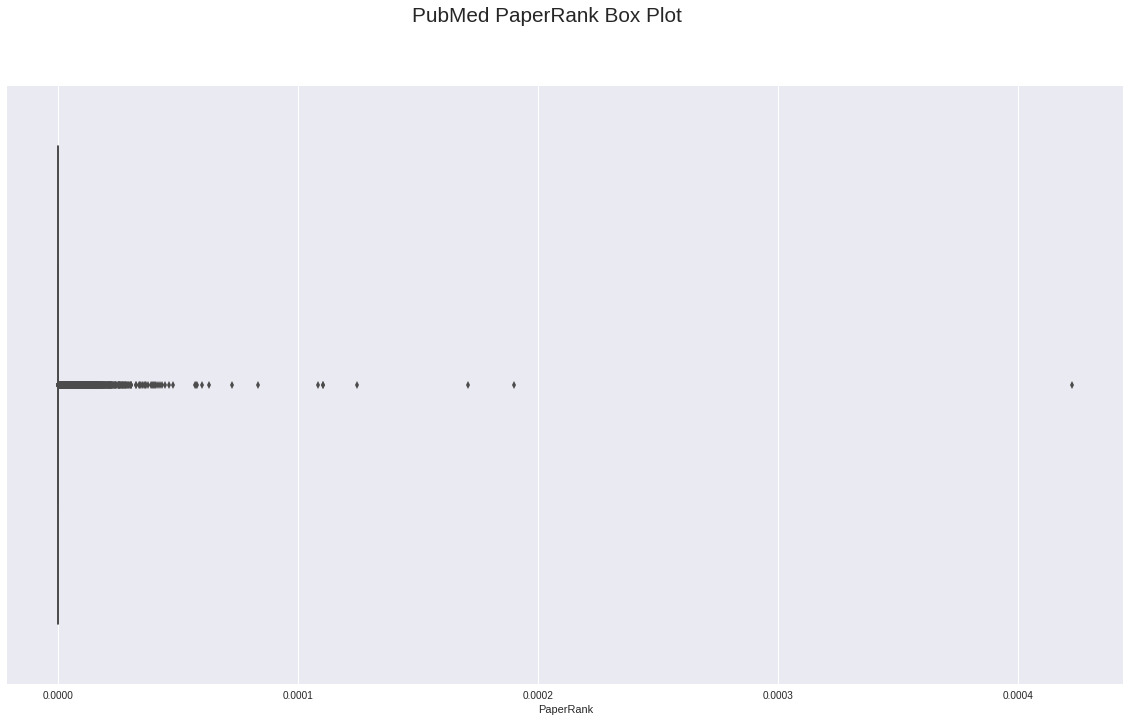

In [17]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank Box Plot')
bp = sns.boxplot(x=pr_rank, ax=ax)
bp.set_xlabel('PaperRank')

Unfortunately, this plot is not very useful. The figure indicates that the majority of ranks are clustered at the lower end of the spectrum. Qualitatively, this makes sense as the majority of publications are not highly cited; and thus have a low PaperRank.

Text(0.5,0,'Log PaperRank')

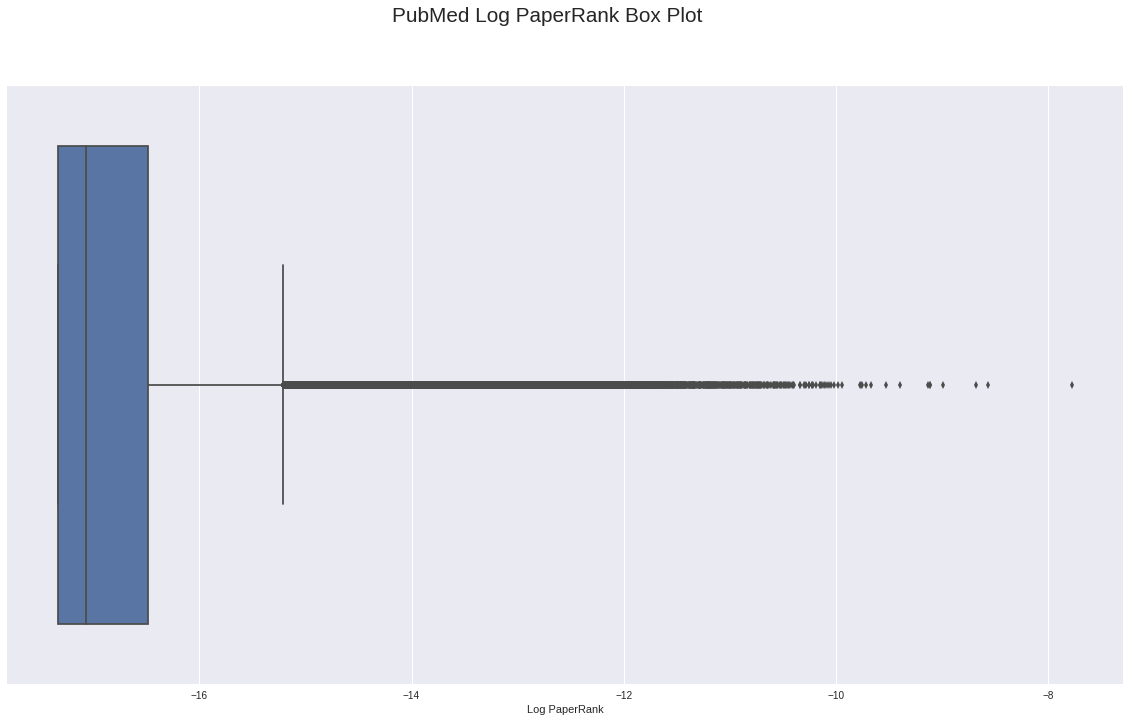

In [18]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed Log PaperRank Box Plot')
bp = sns.boxplot(x=pr_log, ax=ax)
bp.set_xlabel('Log PaperRank')

#### Histogram

To better understand the distribution of the PaperRanks, we will plot a histogram of the data.

Text(0,0.5,'Count')

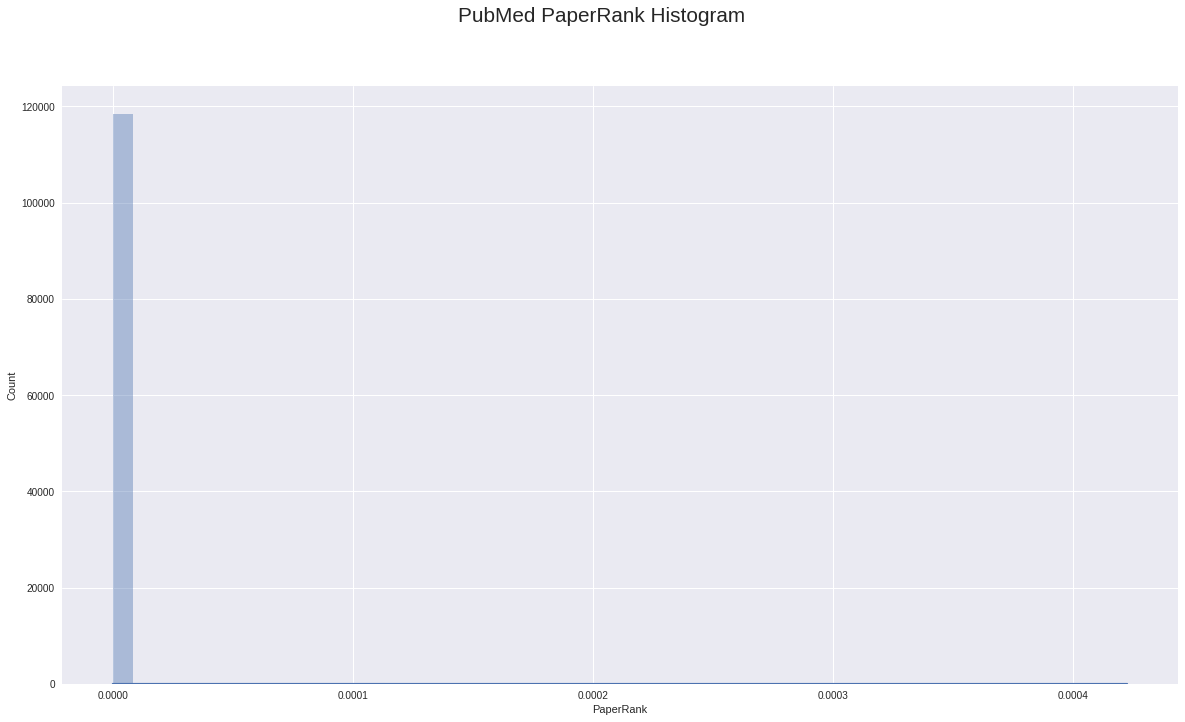

In [19]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank Histogram')
dp = sns.distplot(pr_rank, kde=True, rug=False, ax=ax)
dp.set_xlabel('PaperRank')
dp.set_ylabel('Count')

As with the box plot, the graph of the vanilla PaperRanks is not too informative. This is again due to the high skew and kurtosis of the distribution. Because of this, we well consider the histogram of  `log` of the PaperRanks again.

Text(0,0.5,'Density')

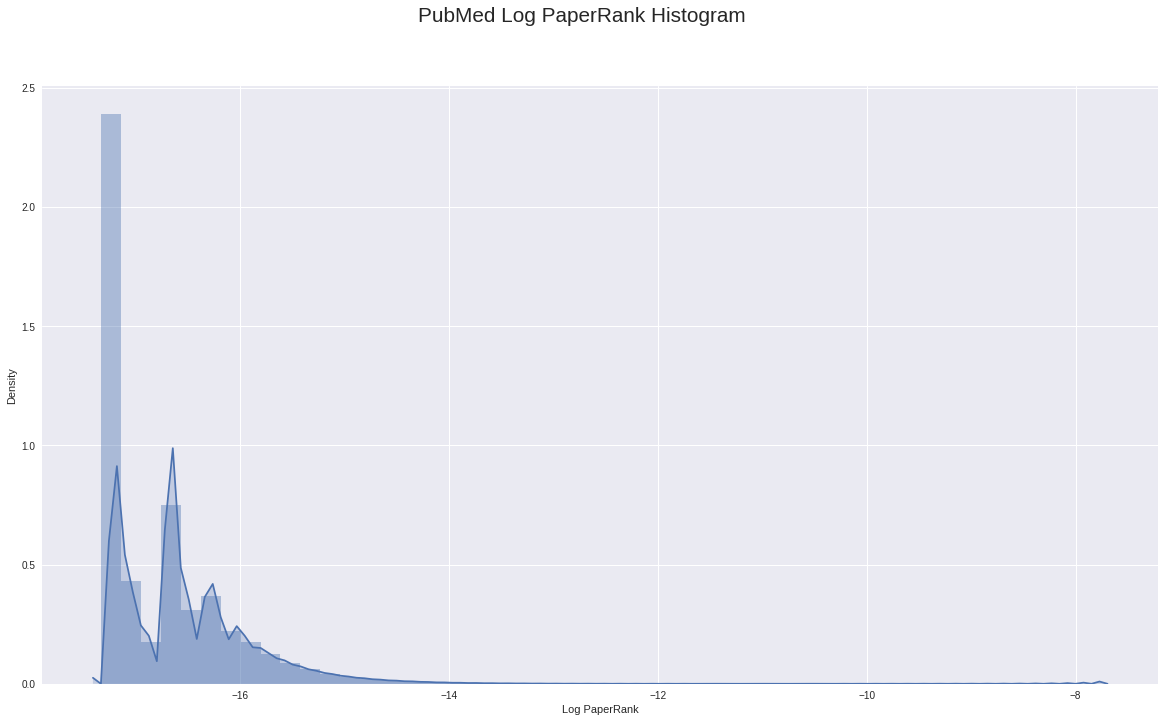

In [20]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed Log PaperRank Histogram')
dp = sns.distplot(pr_log, kde=True, rug=False, kde_kws={'shade': True}, ax=ax)
dp.set_xlabel('Log PaperRank')
dp.set_ylabel('Density')

Interestingly, this histogram suggests a slight bimodality in the distribution. While this behavior is not visible in the plot of the vanilla PaperRanks, it is apparent in the log plot. This is further backed up by the Kernel Density Estimator (KDE) plot on the graph.

Possible models to fit to may include: *Benford's Law*, *Exponential Decay*, some type of cox model?

#### Scatter Plot

Text(0,0.5,'PaperRank')

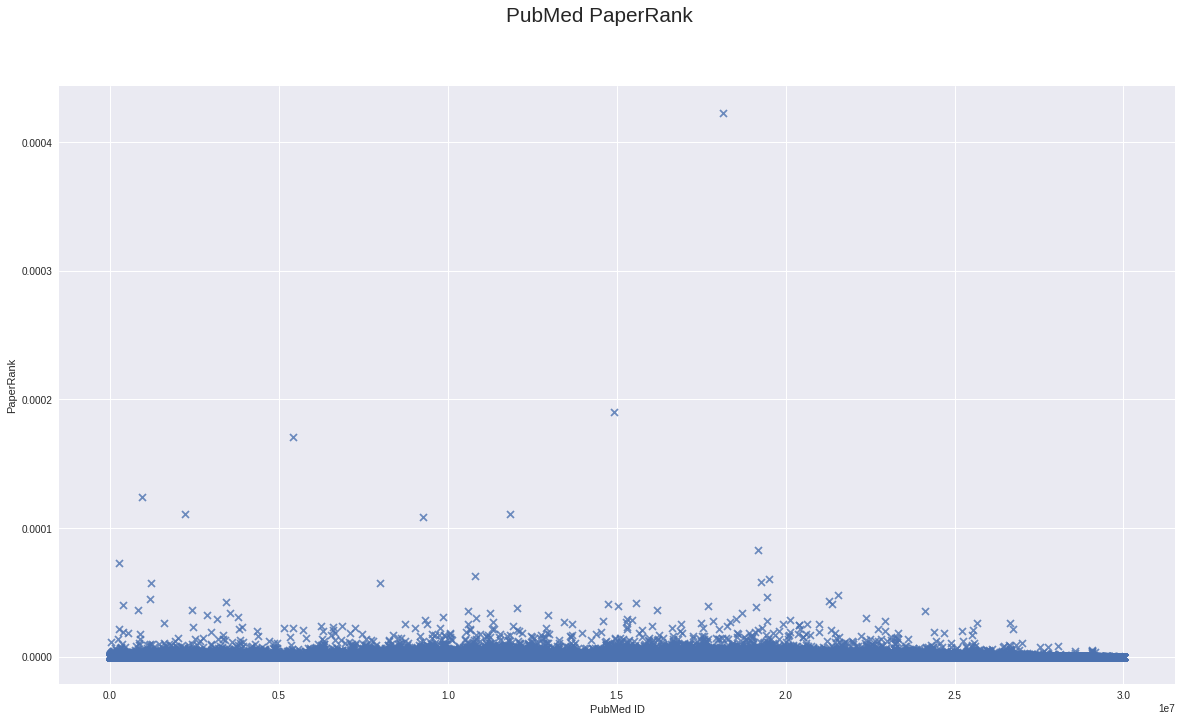

In [21]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed PaperRank')
rp = sns.regplot(x=pr_id, y=pr_rank, fit_reg=False, ax=ax, marker='x')
rp.set_xlabel('PubMed ID')
rp.set_ylabel('PaperRank')

Text(0,0.5,'Log PaperRank')

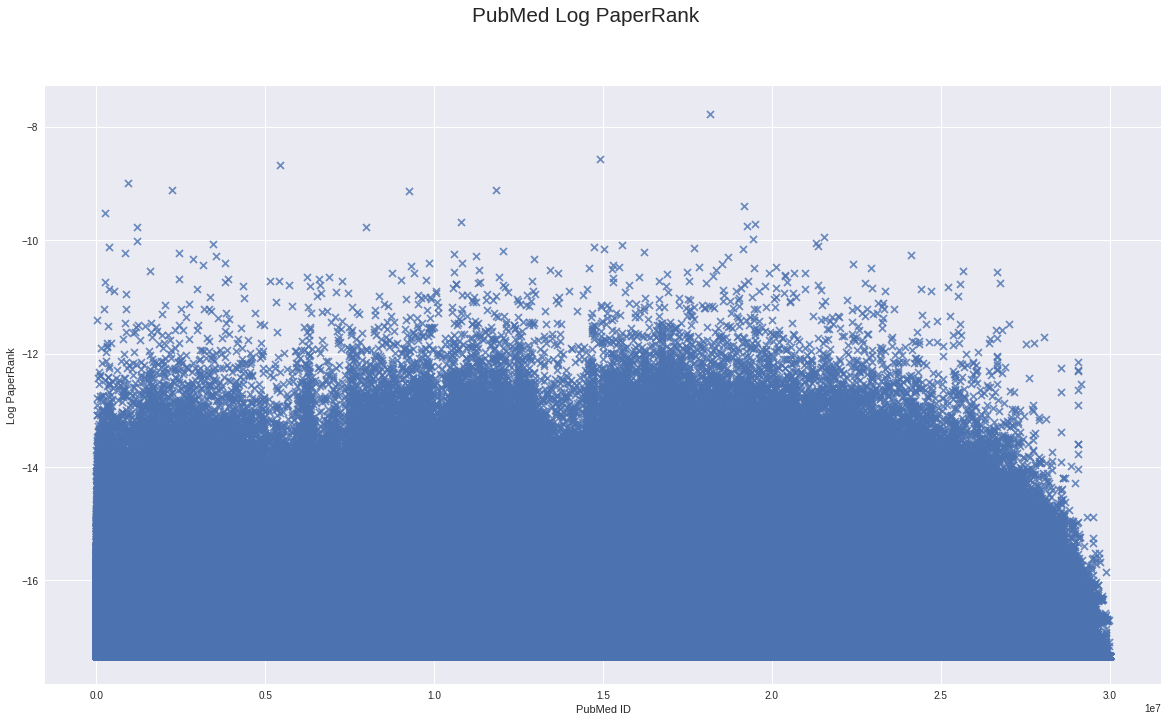

In [22]:
fig, ax = getSubplot(dims_large)
fig.suptitle('PubMed Log PaperRank')
rp = sns.regplot(x=pr_id, y=pr_log, fit_reg=False, ax=ax, marker='x')
rp.set_xlabel('PubMed ID')
rp.set_ylabel('Log PaperRank')

This plot is significantly more insightful. While it does still indicate that a bulk of the PaperRanks are indeed clustered toward the bottom of the distribution, it also captures the noticable decline in PaperRanks towards the end of the sequence of PubMed IDs.

As identified during the scraping process, the PubMed IDs are a **weak** sorting heuristic, ordering the data by time. It is to be expected that newer publications would have a lower PaperRank on average, as they have not been cited by publications yet. This expectation is reflected in the scatterplot.

## Frequency Distribution Analysis

In [0]:
# Investigating counts of higher PaperRanks
# This returns a sorted array of unique PaperRanks, and their counts
pr_unique, pr_counts = np.unique(pr_rank, return_counts=True)

# Building frequency table
pr_frequency = pd.DataFrame({'PaperRank': pr_unique,
                             'Count': pr_counts})

# Defining analysis length
a_len = 25

### Max PaperRank Publication Analysis

The following code sorts the counts from highest to lowest. Then, it creates a table of these sorted counts and the corresponding PaperRank (of length `a_len`). Additionally, we also compute a `Z-Score` for each of the PaperRanks, defined as follows:
$$
\text{Let $i^{\text{th}}$ PaperRank } = x_i \\
\text{Let Z-Score of $i^{\text{th}}$ PaperRank} = Z_i \\
\Rightarrow x_i = \mu_{\text{PaperRank}} + Z_i \cdot \sigma_{\text{PaperRank}} \\
\therefore \, Z_i = \frac{x _i- \mu_{\text{PaperRank}}}{\sigma_{\text{PaperRank}}}
$$

In [18]:
# Sorting counts
pr_counts_sorted = np.argsort(pr_counts)[::-1]

# Getting max counts, unique, and Z-Score
pr_counts_max = pr_counts[pr_counts_sorted[0:a_len]]
pr_unique_max = pr_unique[pr_counts_sorted[0:a_len]]
pr_unique_max_log = np.log(pr_unique_max)
pr_z_max = (pr_unique_max - pr_stats['mean']) / pr_stats['sd']

# Building maximum frequencies table
pr_freq_max = pd.DataFrame({'PaperRank': pr_unique_max,
                            'Log PaperRank': pr_unique_max_log,
                            'Count': pr_counts_max,
                            'Z-Score': pr_z_max})

# Displaying table
display(HTML(pr_freq_max.to_html(index=False)))

Count,Log PaperRank,PaperRank,Z-Score
4093546,-17.333065,2.967191e-08,-0.184123
12192,-16.339822,8.011345e-08,0.051770
5919,-16.672964,5.741476e-08,-0.054382
5812,-16.668095,5.769499e-08,-0.053072
5801,-16.662042,5.804528e-08,-0.051433
5782,-16.683153,5.683274e-08,-0.057104
5741,-16.680313,5.699441e-08,-0.056348
5733,-16.689574,5.646898e-08,-0.058805
5719,-16.687715,5.657407e-08,-0.058314
5704,-16.685595,5.669417e-08,-0.057752


As alluded to by the distribution of PaperRanks, the majority of the PaperRanks are clustered toward the mean of the distribution. This is indicated by the low `Z-Score` of each of the PaperRanks.

### Outlier Analysis

As indicated by the very high skew and kurtosis, and as evidenced by the table above, this distribution is very right-skewed. Qualitatively, this means that a majority of publications have a very low PaperRank, and have not been cited extensively. Taking the inverse of this, it means that a few publications are cited very highly. This makes sense in the context of publications; certain works are considered to be extremely influential, while the majority of work is not always built on further.

In this section, we order the data by frequency, and examine the set of outliers on the right end of the distribution. That is, we are examining the articles on PubMed that have the highest PaperRanks. To do this, we simply extract the highest `a_len` PaperRanks, and download the publication metadata for each of the publications.

The following code builds the table of highest PaperRanks, and gets the metadata for each of the publications.

In [19]:
# Creating list of max IDs and ranks
pr_id_max = pr_id[pr_sort_idx[0:a_len]]
pr_rank_max = pr_rank[pr_sort_idx[0:a_len]]

# Updating Z-scores
pr_z_max = (pr_rank_max - pr_stats['mean']) / pr_stats['sd']

pr_freq_head_metadata = pd.DataFrame(columns=['Rank', 'PubMed ID', 'PaperRank',
                                              'Z-Score', 'Title', 'Authors',
                                              'Year', 'Abstract'])

# Building metadata table
for i in range(a_len):
  current_id = str(pr_id_max[i])
  rowdata = [i + 1, current_id, pr_rank_max[i], pr_z_max[i],
             *getPublicationMetadata(current_id)]
  pr_freq_head_metadata.loc[i] = rowdata
  

# Changing Pandas display settings to show full table
pd.set_option('max_colwidth', 1000)
pd.set_option('expand_frame_repr', True)

# Display table
display(HTML(pr_freq_head_metadata.to_html(index=False)))

# Reset Pandas settings
pd.reset_option('max_colwidth')
pd.reset_option('expand_frame_repr')

Rank,PubMed ID,PaperRank,Z-Score,Title,Authors,Year,Abstract
1,18156677,0.000423,1975.811514,A short history of SHELX.,Sheldrick GM,2008,"An account is given of the development of the SHELX system of computer programs from SHELX-76 to the present day. In addition to identifying useful innovations that have come into general use through their implementation in SHELX, a critical analysis is presented of the less-successful features, missed opportunities and desirable improvements for future releases of the software. An attempt is made to understand how a program originally designed for photographic intensity data, punched cards and computers over 10000 times slower than an average modern personal computer has managed to survive for so long. SHELXL is the most widely used program for small-molecule refinement and SHELXS and SHELXD are often employed for structure solution despite the availability of objectively superior programs. SHELXL also finds a niche for the refinement of macromolecules against high-resolution or twinned data; SHELXPRO acts as an interface for macromolecular applications. SHELXC, SHELXD and SHELXE ..."
2,14907713,0.000190,888.671988,Protein measurement with the Folin phenol reagent.,"LOWRY OH, ROSEBROUGH NJ, FARR AL, RANDALL RJ",1951,
3,5432063,0.000171,797.958901,Cleavage of structural proteins during the assembly of the head of bacteriophage T4.,Laemmli UK,1970,
4,942051,0.000124,581.521568,A rapid and sensitive method for the quantitation of microgram quantities of protein utilizing the principle of protein-dye binding.,Bradford MM,1976,
5,2231712,0.000111,516.653379,Basic local alignment search tool.,"Altschul SF, Gish W, Miller W, Myers EW, Lipman DJ",1990,"A new approach to rapid sequence comparison, basic local alignment search tool (BLAST), directly approximates alignments that optimize a measure of local similarity, the maximal segment pair (MSP) score. Recent mathematical results on the stochastic properties of MSP scores allow an analysis of the performance of this method as well as the statistical significance of alignments it generates. The basic algorithm is simple and robust; it can be implemented in a number of ways and applied in a variety of contexts including straightforward DNA and protein sequence database searches, motif searches, gene identification searches, and in the analysis of multiple regions of similarity in long DNA sequences. In addition to its flexibility and tractability to mathematical analysis, BLAST is an order of magnitude faster than existing sequence comparison tools of comparable sensitivity."
6,11846609,0.000111,516.627684,Analysis of relative gene expression data using real-time quantitative PCR and the 2(-Delta Delta C(T)) Method.,"Livak KJ, Schmittgen TD",2001,"The two most commonly used methods to analyze data from real-time, quantitative PCR experiments are absolute quantification and relative quantification. Absolute quantification determines the input copy number, usually by relating the PCR signal to a standard curve. Relative quantification relates the PCR signal of the target transcript in a treatment group to that of another sample such as an untreated control. The 2(-Delta Delta C(T)) method is a convenient way to analyze the relative changes in gene expression from real-time quantitative PCR experiments. The purpose of this report is to present the derivation, assumptions, and applications of the 2(-Delta Delta C(T)) method. In addition, we present the derivation and applications of two variations of the 2(-Delta Delta C(T)) method that may be useful in the analysis of real-time, quantitative PCR data."
7,9254694,0.000108,506.743360,Gapped BLAST and PSI-BLAST: a new generation of protein database search programs.,"Altschul SF, Madden TL, Schäffer AA, Zhang J, Zhang Z, Miller W, Lipman DJ",1997,"The BLAST programs are widely used tools for searching protein and DNA databases for sequence similarities. For protein comparisons, a variety of definitional, al

## Bayesian Gaussian Mixture Model

- Bimodality evident from the histogram of log paperranks
- Structure reflects real world; breaks into 3 categories:
  - Untrusted papers (uncited/very low citations)
  - Trusted papers (moderately cited)
  - Highly trusted papers (very cited)

### Overview

Interpreting the distribution analysis above, the histogram of the `Log PaperRank` stands out in particular ([Log PaperRank Histogram](#scrollTo=F7GlUvMs5PVc)). It suggests a distinct bimodality in the data.

A possible explanation of this bimodality can be developed by considering the nature of the underlying process the PubMed PaperRank is modeling. Academic publications are - in practice - judged by the number of citations they gather. It is also a fair assertion that - by definition - most publications are not highly cited. Rather, it is a few publications that tend to get cited a disproportionate amount of times ([Outlier Analysis](#scrollTo=unTGsWdpYl5f)), compared to the average. It can also be observed that the majority of scientific publications do not go on to be cited, and are thus *dangling* nodes in the PubMed PaperRank graph.

This is the behavior is reflected in the histogram - the majority are not cited (the first mode), and the second-largest group are the papers the are cited an average number of times. The effect of a few ouliers being cited disproportionately more than the rest is seen in the long tail of the distribution.

Following this observation, we defined 3 categories, to capture the gist of the features of the underlying Academic Publication process.

1. *Not Trusted*
2. *Trusted*
3. *Highly Trusted*

With the end goal of predicting the probability of each element being in a given category, we model the `Log PaperRank` as a Mixed Gaussian Distribution. Specifically, a [Variational Bayesian estimation of a Gaussian Mixture](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), with a priori weights dervied from a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution).

### Heuristic Convergence Test

To verify the heuristic, we conducted a series of convergence tests for a Variational Bayesian Mixed Gaussian Distribution by computing a mixture model with 3 components, with a priori weights derived from a Dirichlet distribution. 

To do this, we used [`sklearn.mixture.BayesianGaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture).

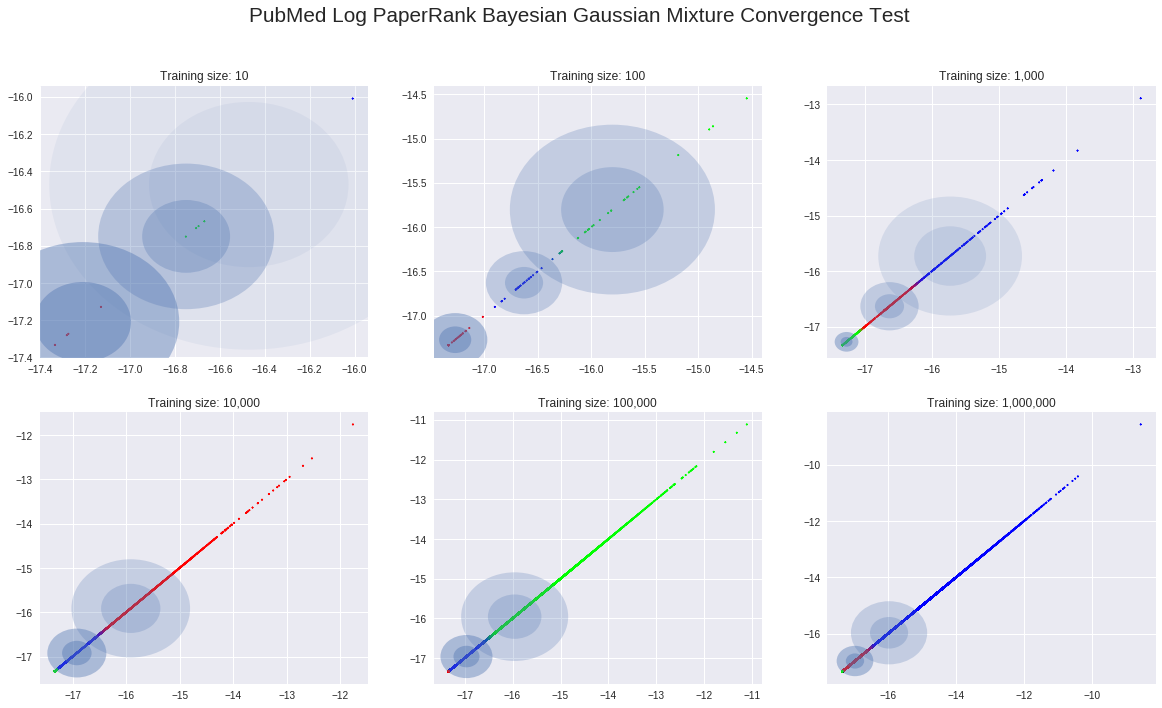

In [19]:
# Create split plot to show all training sizes
# fig, axs = plt.subplots(2, 3, figsize=dims_large, sharex='all', sharey='all')
fig, axs = plt.subplots(2, 3, figsize=dims_large)

# Set title
fig.suptitle('PubMed Log PaperRank Bayesian Gaussian Mixture Convergence Test',
             fontsize='xx-large')

# Iterate in powers of 10 from 10 to 1,000,000
for i in range(1, 7):
  # Set idx (for subplot indexing)
  idx = i - 1
  nrow = int(idx / 3)
  ncol = idx % 3

  # Set axes
  ax = axs[nrow][ncol]
  
  # Set training size
  train_size = 10**i
  
  # Sample training set from full distribution
  pr_train = np.random.choice(pr_log, train_size)
  
  # Instantiate model
  model = mixture.BayesianGaussianMixture(n_components=3,
                                          covariance_type='diag')

  # Create data object for model
  X = np.array([pr_train, pr_train]).T
  
  # Predict entire training dataset
  preds = model.fit(X).predict_proba(X)
  
  # Plot graph
  drawMixtureModel(model=model, preds=preds, X=X, ax=ax)

### Model Training

**NOTE: THIS TAKES A LONG TIME; DO NOT RUN UNLESS NECESSARY**

In [0]:
# Training the model

# Input Data
X = np.array([pr_log, pr_log]).T

# Instantiating Model
global pr_model
pr_model = mixture.BayesianGaussianMixture(n_components=3,
                                           covariance_type='diag')

# Training model on entire dataset
pr_model_full = pr_model.fit(X)

### Model Analysis

#### Visualization

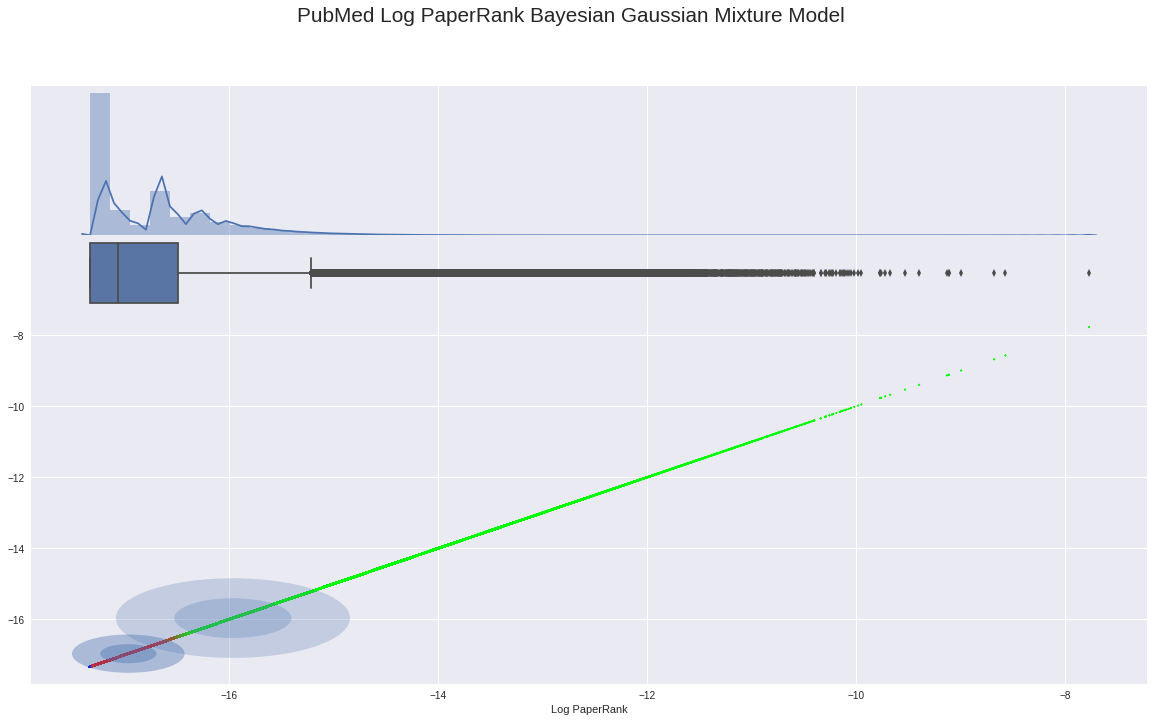

In [21]:
# Create split plot to show histogram and boxplot with model graph
fig, axs = plt.subplots(3, 1, figsize=dims_large, sharex=True,
                        gridspec_kw={'height_ratios':[2,1,5], 'hspace': 0})

# Set title
fig.suptitle('PubMed Log PaperRank Bayesian Gaussian Mixture Model',
             fontsize='xx-large')


# Top plot
#---------

# Set axes
ax = axs[0]
# Plot Histogram
sns.distplot(pr_log, kde=True, rug=False, ax=ax)
# Clear y-axis ticks
ax.set_yticks([])

# Middle plot
#---------

# Set axes
ax = axs[1]
# Plot Box plot
sns.boxplot(pr_log, ax=ax)

# Bottom plot
#------------

# Set axes
ax = axs[2]
ax.set_xlabel('Log PaperRank')
# Predict over entire dataset
pr_preds = pr_model_full.predict_proba(X)
# Clean predictions, save
global pr_preds
pr_preds = np.copy(cleanPredictions(pr_preds))
# Plot graph
drawMixtureModel(model=model, preds=pr_preds, X=X, ax=ax, set_title=False)

#### Parameters

In [22]:
# Model characteristics
global pr_model_stat
pr_model_stat = dict()

# Getting mean and variance
pr_model_stat['mean'] = [a[0] for a in model.means_]
pr_model_stat['var'] = [a[0] for a in model.covariances_]

# Cleaning model predictions, mean and variance
# Note: We know the means must be in ascending order
order = list(np.argsort(pr_model_stat['mean']))
pr_model_stat['mean'] = cleanParameter(pr_model_stat['mean'], order)
pr_model_stat['var'] = cleanParameter(pr_model_stat['var'], order)

# Create DataFrame
pr_model_stat_df = pd.DataFrame(pr_model_stat)

# Set index and index title
pr_model_stat_df.index.name = 'Components'
pr_model_stat_df.index = ['Not Trusted', 'Trusted', 'Highly Trusted']

pr_model_stat_df

,mean,var
Not Trusted,-17.333063,0.000003
Trusted,-16.964418,0.072570
Highly Trusted,-15.962977,0.313746


### Model Explorer

*Follow the instructions [here](#scrollTo=f3Y5KASErnH6) for this to work.*

To efficiently explore the model, this search engine allows users to query the regular PubMed search API, and plot the probability of the results being in each of the 3 categories.

Type a `search_term` and press play (or `⌘/Ctrl+Enter`).

Use the PubMed website to help construct complex queries: https://www.ncbi.nlm.nih.gov/pubmed/?term=.

To visit the website for a specific PubMed ID, append it to the end of https://www.ncbi.nlm.nih.gov/pubmed/.
  - Eg: https://www.ncbi.nlm.nih.gov/pubmed/20658405

**NOTE: The results may take a few moments to load.**

In [23]:
#@title PubMed Search

search_term = '' #@param {type:"string"}

# Getting search results
result_id = pubMedSearch(search_term)

# Defining result DataFrame
result = pd.DataFrame(columns=['PubMed ID', 'Log PaperRank', 'Pr(Not Trusted)',
                               'Pr(Trusted)', 'Pr(Highly Trusted)', 'Title',
                               'Authors', 'Year'])

# Defining base link
base_link = 'https://www.ncbi.nlm.nih.gov/pubmed/'

for i in range(len(result_id)):
  # Isolating current ID
  current_id = result_id[i]

  try:
    # Getting MetaData
    metadata = getPublicationMetadata(str(current_id))

   # Getting prediction index
    pred_idx = np.where(current_id == pr_id)[0][0]
  except:
    # Skip if not found
    continue

  # Getting prediction
  pred = pr_preds[pred_idx]
  
  # Getting PaperRank
  pr = pr_log[pred_idx]
  
  # Adding to result
  rowdata = [current_id, pr, *pred, metadata[0], metadata[1], metadata[2]]
  result.loc[i] = rowdata

  # Displaying table
display(HTML(result.to_html(index=False)))

PubMed ID,Log PaperRank,Pr(Not Trusted),Pr(Trusted),Pr(Highly Trusted),Title,Authors,Year
